In [1]:
import os
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models
from hipposlam.utils import Recorder
from hipposlam.Networks import VAE
from hipposlam.Sequences import StateTeacher
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from os.path import join
from glob import glob
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from skimage.io import imsave
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
import umap
from try_VAE import EmbeddingImageDataset, get_dataloaders, VAELearner
from sklearn.decomposition import PCA
from pycircstat.descriptive import cdiff


In [34]:
kld_mul = 0.01

model_tag = f'kldmul={kld_mul:0.6f}_bottle3'



data_dir = join('data', 'VAE')
load_embed_dir = join(data_dir, 'embeds')
load_annotation_pth = join(data_dir, 'annotations.csv')
load_ckpt_pth = join(data_dir, 'model', model_tag, f'ckpt_{model_tag}.pt')
save_plot_dir = join(data_dir, 'plots')
os.makedirs(save_plot_dir, exist_ok=True)

# Prepare datasets
train_dataloader, test_dataloader, train_dataset, test_dataset = get_dataloaders(load_annotation_pth, load_embed_dir)

# Model
vaelearner = VAELearner(input_dim=576,
                        hidden_dims=[400, 200, 100, 50, 25, 10, 3],
                        kld_mul=0.1,
                        lr=0.001,
                        lr_gamma=0.95,
                        weight_decay=0)
vaelearner.load_checkpoint(load_ckpt_pth)



In [35]:
# Predict bottlenecks and store
vaelearner.vae.eval()

mu_train_tmp = []
mu_test_tmp = []

labels_train_tmp = []
labels_test_tmp = []

for x_train, label_train in iter(train_dataloader):
    _, _, (y, mu_train, _) = vaelearner.infer(x_train)
    mu_train_tmp.append(mu_train)
    labels_train_tmp.append(label_train)
mus_train = torch.vstack(mu_train_tmp)
labels_train = torch.vstack(labels_train_tmp)

for x_test, label_test in iter(test_dataloader):
    _, _, (y, mu_test, _) = vaelearner.infer(x_test)
    mu_test_tmp.append(mu_test)
    labels_test_tmp.append(label_test)
mus_test = torch.vstack(mu_test_tmp)
labels_test = torch.vstack(labels_test_tmp)



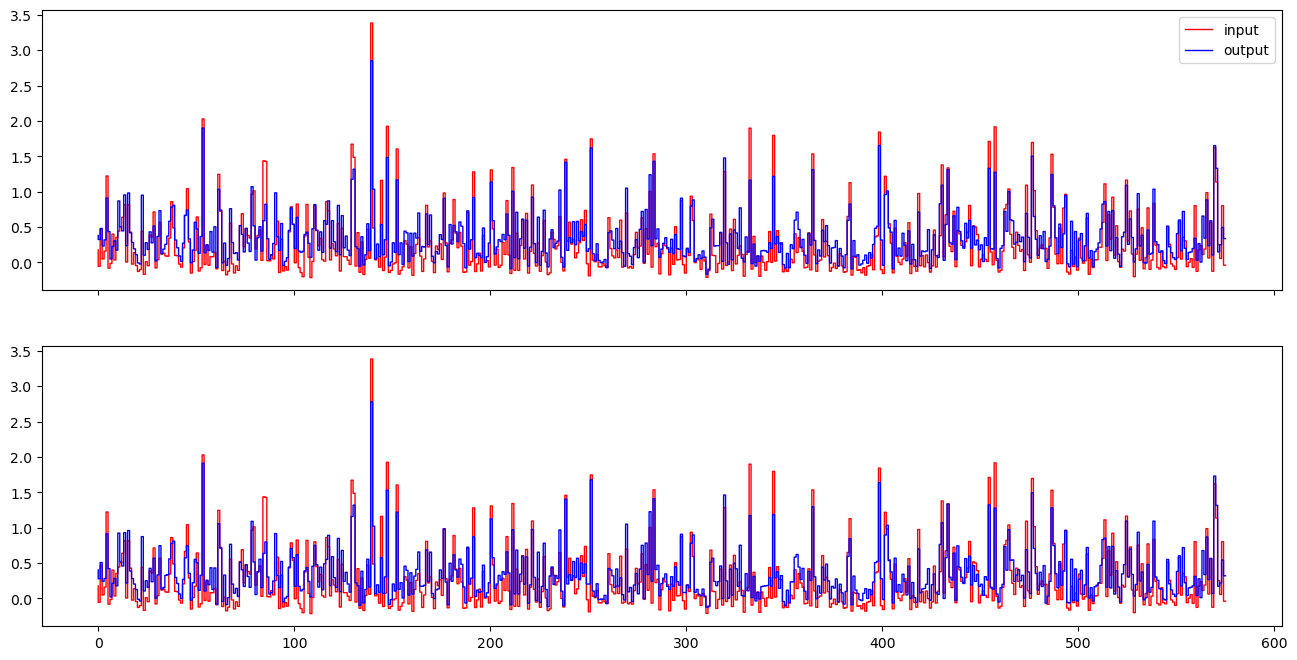

In [36]:
# Plot examples
nexamples = 2
fig, ax = plt.subplots(nexamples, 1, figsize=(16, 8), sharex=True)
x_ax = np.arange(x_test.shape[1])
for i in range(nexamples):
    x_test_each = x_test[[i], ...]
    loss_test, (recon_loss_test, kld_loss_test), (y, mu, logvar) = vaelearner.infer(x_test_each)
    ax[i].step(x_ax, x_test[0, :], color='r', label='input', linewidth=1)
    ax[i].step(x_ax, y[0, :], color='b', label='output', linewidth=1)
ax[0].legend()




In [37]:
# Fit UMAP
mus = torch.vstack([mus_train, mus_test])
labels = torch.vstack([labels_train, labels_test])
umap_model = umap.UMAP(n_neighbors=50,
                      min_dist=0.1,
                      metric='cosine',
                       n_components=2)
umap_embeds = umap_model.fit_transform(mus)

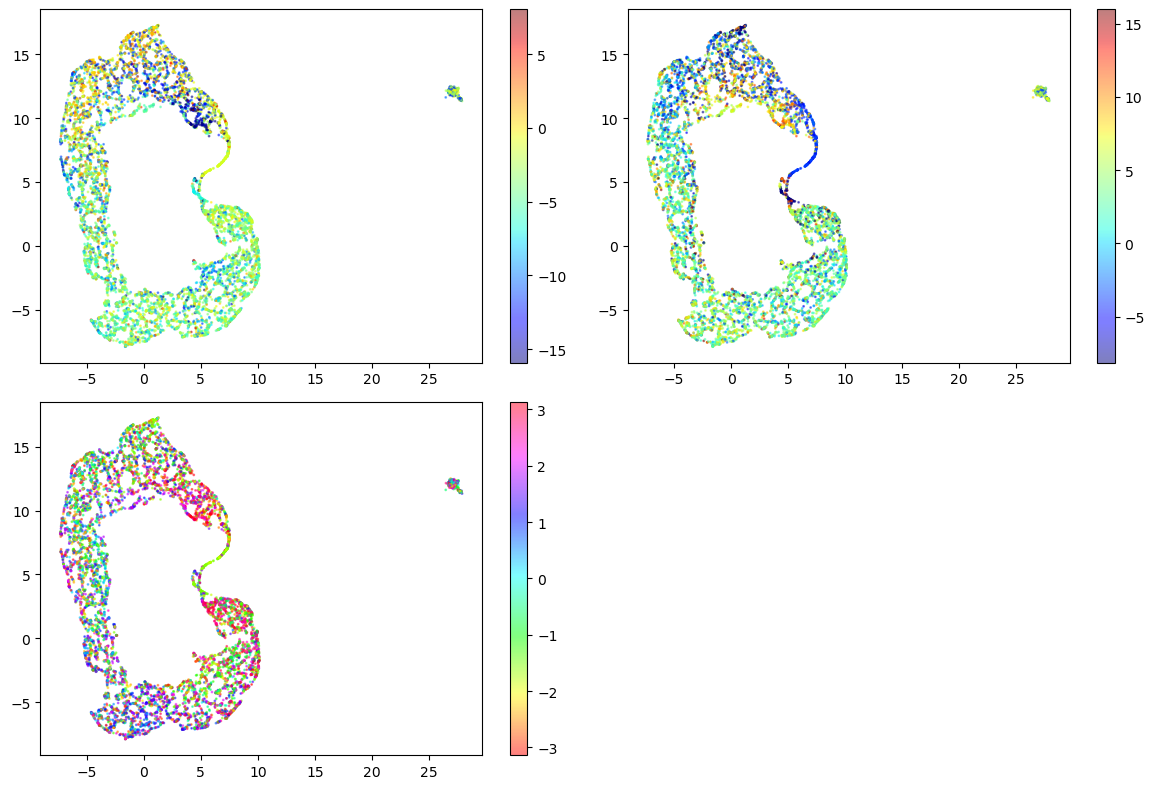

In [38]:

umap_embeds_toplot = umap_embeds
labels_toplot = labels
fig = plt.figure(figsize=(12, 8))

ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)

ax= ax.ravel()
im0 = ax0.scatter(umap_embeds_toplot[:, 0], umap_embeds_toplot[:, 1], s=1, c=labels_toplot[:, 0], cmap='jet', alpha=0.5)
plt.colorbar(im0, ax=ax0)
im1 = ax1.scatter(umap_embeds_toplot[:, 0], umap_embeds_toplot[:, 1], s=1, c=labels_toplot[:, 1], cmap='jet', alpha=0.5)
plt.colorbar(im1, ax=ax1)
im2 = ax2.scatter(umap_embeds_toplot[:, 0], umap_embeds_toplot[:, 1], s=1, c=labels_toplot[:, 2], cmap='hsv', alpha=0.5)
plt.colorbar(im2, ax=ax2)

fig.tight_layout()

fig.savefig(join(save_plot_dir, f'Umap_{model_tag}.png'), dpi=300)

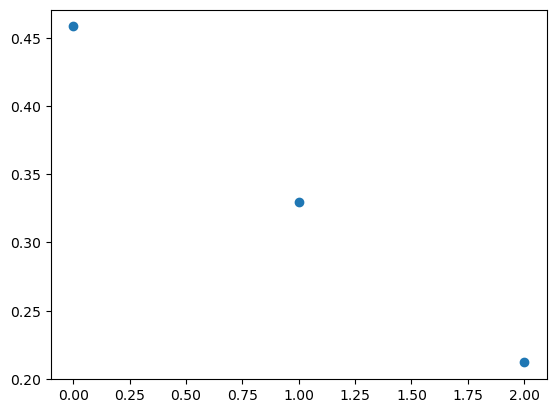

In [28]:
pca = PCA()
pca.fit(mus)
varr = pca.explained_variance_ratio_
plt.scatter(np.arange(varr.shape[0]), varr)

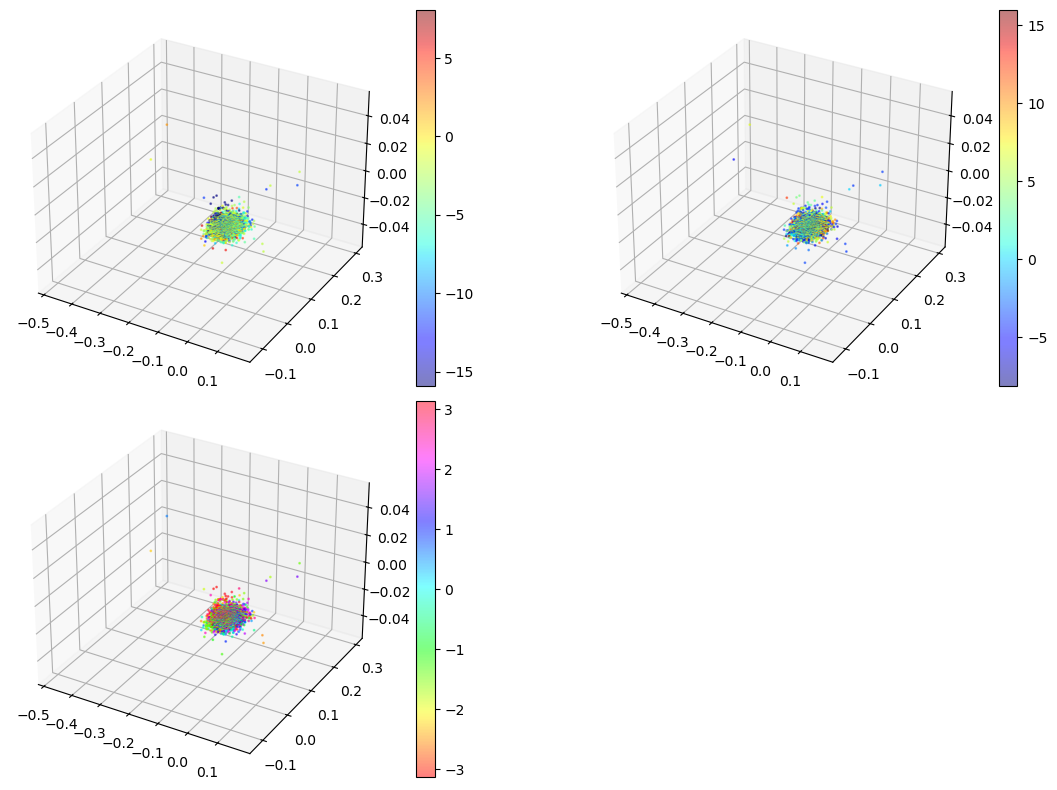

In [33]:
fig = plt.figure(figsize=(12, 8))

ax0 = fig.add_subplot(2, 2, 1, projection='3d')
ax1 = fig.add_subplot(2, 2, 2, projection='3d')
ax2 = fig.add_subplot(2, 2, 3, projection='3d')

ax= ax.ravel()
im0 = ax0.scatter(mus[:, 0], mus[:, 1], s=1, c=labels_toplot[:, 0], cmap='jet', alpha=0.5)
plt.colorbar(im0, ax=ax0)
im1 = ax1.scatter(mus[:, 0], mus[:, 1], s=1, c=labels_toplot[:, 1], cmap='jet', alpha=0.5)
plt.colorbar(im1, ax=ax1)
im2 = ax2.scatter(mus[:, 0], mus[:, 1], s=1, c=labels_toplot[:, 2], cmap='hsv', alpha=0.5)
plt.colorbar(im2, ax=ax2)

fig.tight_layout()
fig.savefig(join(save_plot_dir, f'mus3D_{model_tag}.png'), dpi=300)
